In [1]:

import sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score, roc_curve, auc, precision_recall_curve

import torch, torchtext

## Keras and it's sub modules for Deep Learning models like DNN, CNN etc.
import keras
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D, Activation, Embedding, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.activations import softmax, sigmoid,tanh
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras.models import Model, Sequential
from keras.optimizers import Adagrad, Adam, SGD
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.utils.multi_gpu_utils import Model as ParallelModel
from keras.preprocessing import sequence


## Gradient Boosting Varients
import xgboost as xgb
import catboost as cbt
import lightgbm as lgbm

## Natural Language Processing Library imports
import nltk
from nltk.corpus import stopwords, shakespeare
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk import word_tokenize

## Data Manipulation and loading imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Data Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

## Common Python file/directory creation/manipulation libraries.
import glob
import os
import shutil

## Garbage Collection and warnings imports
import gc
import warnings
import re
import copy

stop_words = stopwords.words(fileids='english')
hamlet = ' '.join(shakespeare.words('hamlet.xml')) 
macbeth = ' '.join(shakespeare.words('macbeth.xml')) 
string_size = 0.20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
pd.set_option('display.max_columns',8)
pd.set_option('precision',3)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(os.listdir("../input"))

Using TensorFlow backend.


['spam-ham']


We are listing all the datasets we have and their location in ../input/spam-ham/spam-ham directory.

In [2]:
%ls ../input/spam-ham/spam-ham/

test_CSDMC2010_SPAM/  test_PU1/              train_ENRON/      train_trec07p/
test_ENRON/           test_trec07p/          train_Ling-Spam/
test_Ling-Spam/       train_CSDMC2010_SPAM/  train_PU1/


In [3]:
## Set root_dir to same as above after you find out where train_ENRON and test_ENRON are residing.
root_dir = '../input/spam-ham/spam-ham/'

Below we are printing all users train mail spam/ham distribution counts

In [4]:
## Around 3.5k -4k(2.5k-3k : Ham, 1k-1.5k : Spam) mails are available for training per user.
counts = {}
print('Train File Counts')
for path in sorted(os.listdir(os.path.join(root_dir, 'train_ENRON'))):
    ham_path,spam_path = os.path.join(root_dir, 'train_ENRON', path,'h','*'), os.path.join(root_dir, 'train_ENRON', path,'s','*')
    print('Number of files in ham path ({0}): {1} '.format(path,len(glob.glob(ham_path))))
    print('Number of files in spam path ({0}): {1} '.format(path,len(glob.glob(spam_path))))    
    counts[path] = [len(glob.glob(ham_path)) + len(glob.glob(spam_path))]

Train File Counts
Number of files in ham path (enron1): 2600 
Number of files in spam path (enron1): 1066 
Number of files in ham path (enron2): 3006 
Number of files in spam path (enron2): 1038 
Number of files in ham path (enron3): 2840 
Number of files in spam path (enron3): 1028 
Number of files in ham path (enron4): 1060 
Number of files in spam path (enron4): 3154 
Number of files in ham path (enron5): 1072 
Number of files in spam path (enron5): 2560 
Number of files in ham path (enron6): 1049 
Number of files in spam path (enron6): 3124 


Below we are printing all users test mail spam/ham distribution counts

In [5]:
## Around 1.5k -2k(1k-1.5k : Ham, 500-1k : Spam) mails are available for test per user.
print('Test File Counts')
for path in sorted(os.listdir(os.path.join(root_dir, 'test_ENRON'))):
    ham_path,spam_path = os.path.join(root_dir, 'test_ENRON', path,'h','*'), os.path.join(root_dir, 'test_ENRON', path,'s','*')
    print('Number of files in ham path ({0}): {1} '.format(path,len(glob.glob(ham_path))))
    print('Number of files in spam path ({0}): {1} '.format(path,len(glob.glob(spam_path))))    
    counts[path].append(len(glob.glob(ham_path)) + len(glob.glob(spam_path)))

Test File Counts
Number of files in ham path (enron1): 1072 
Number of files in spam path (enron1): 434 
Number of files in ham path (enron2): 1355 
Number of files in spam path (enron2): 458 
Number of files in ham path (enron3): 1172 
Number of files in spam path (enron3): 472 
Number of files in ham path (enron4): 440 
Number of files in spam path (enron4): 1346 
Number of files in ham path (enron5): 428 
Number of files in spam path (enron5): 1115 
Number of files in ham path (enron6): 451 
Number of files in spam path (enron6): 1376 


Below we are checking percentage of emails present in train and test sets.

In [6]:
## One can notice below that we have kept 70% data as training and 30% as final test. 
## We'll be dividing this 70% and train model on it and then evaluate trained model on remaining 30% data to finalize.
for key, value in sorted(counts.items(), key = lambda x: x[0]):
    print(key + ' : Train : %.2f %%, Test : %.2f %%'%(value[0]*100/sum(value), value[1]*100/sum(value)))

enron1 : Train : 70.88 %, Test : 29.12 %
enron2 : Train : 69.05 %, Test : 30.95 %
enron3 : Train : 70.17 %, Test : 29.83 %
enron4 : Train : 70.23 %, Test : 29.77 %
enron5 : Train : 70.18 %, Test : 29.82 %
enron6 : Train : 69.55 %, Test : 30.45 %


### Gathering train and test file names
Below method takes as input train and test path where spam and ham mails are stored in folder named `s` and `h` respectively. It also takes as input username as parameter `user` to get file names of particular user.

In [7]:
def gather_train_test_file_names(train_root, test_root, user):
    train_spam_x = glob.glob('%s/%s/s/*'%(train_root, user)) ## Get all file names for spam mails in train directory
    train_ham_x = glob.glob('%s/%s/h/*'%(train_root, user)) ## Get all file names for ham mails in train directory

    test_spam_x = glob.glob('%s/%s/s/*'%(test_root, user)) ## Get all file names for spam mails in test directory
    test_ham_x = glob.glob('%s/%s/h/*'%(test_root, user))  ## Get all file names for ham mails in test directory
    
    train_x = train_spam_x + train_ham_x ## Joining spam and ham mail file names for train data

    y_train_ham = np.zeros(len(train_ham_x))
    y_train_spam = np.ones(len(train_spam_x))
    y_train = np.concatenate((y_train_spam,y_train_ham)) ## Creating target labels same as that of train mails
    
    test_x = test_spam_x+test_ham_x ## Joining spam and ham mail file names for test data

    y_test_spam = np.ones(len(test_spam_x))
    y_test_ham = np.zeros(len(test_ham_x))
    y_test = np.concatenate((y_test_spam,y_test_ham)) ## Creating target labels same as that of test mails
    
    del train_spam_x,train_ham_x, test_spam_x,test_ham_x, y_train_ham, y_train_spam, y_test_spam, y_test_ham

    gc.enable();gc.collect();
    
    return train_x, test_x, y_train, y_test

### Clean Data
Below method takes as input all list of file names and performs below mentioned steps

1. Loops through each file
2. Word tokenize file contents ignoring unwanted characters using ISO-8859-1 encoding
3. Remove stop words which are commonly occuring words in sentence and does not contribute much to classification.
4. Reconstruct text contents after all above steps properly cleans data.

In [8]:
def clean_data(x_total):
    """
    Below method loop through each file names provided as list to it. Then it reads file contents tokenize it
    using word_tokenize of nltk. It then lemmatize all words. It then removes unwanted characters from words like
    punctuation marks. It then removes stop words which are quite common words like if,the, where which are quite
    common in sentences and useless for classification tasks.
    """
    x_all = np.empty_like(x_total)
    regex = re.compile(r'[a-z]+')
    for i, file_name in enumerate(x_total): 
        with open(file_name, encoding='ISO-8859-1') as f:
            #print(file_name)
            #print(f.read())
            words = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in  word_tokenize(f.read().lower())] # tokenize string and then lemmatize.
            words = [regex.match(word).string for word in words if regex.match(word)] ## Removes punctuation marks and unwanted characters.
            words = [word for word in words if regex.match(word) if word not in stop_words] ## Removes stop words.
            x_all[i] = ' '.join(words) ## Create string again after performing all above steps.
    
    #print('Check whether length is same as original data : ',len(x_all) == len(x_total))

    return x_all

### Prepare Datasets for training and evaluation
Below method loops through files of all users making use of `gather_train_test_file_names` defined above and reads all mails data for each user one by one. It then uses `clean_data` method defined above to cleane data read from each file for each users and creating proper train/test datasets for each users. It maintains data for each user in `all_users_train_test_data` dictionary with key as username and value as list fo train/test datasets for that user.

In [9]:
def prepare_datasets():
    """
    This method loops through train and test datasets of each user one by one and then store them as list (train_x, y_train, test_x,y_test)
    in all_users_train_test dictionary.
    """
    for i in range(1,7):
        user = 'enron%d'%i
        print('User : ', user)
        enron_train_root = os.path.join(root_dir, 'train_ENRON')
        enron_test_root = os.path.join(root_dir, 'test_ENRON')
        #print(enron_train_root)
        train_x, test_x, y_train, y_test = gather_train_test_file_names(enron_train_root, enron_test_root, user) ## Gathers all file names for train and test sets for particular user

        print('Train (X, Y): ',len(train_x),len(y_train))
        print('Test (X, Y): ',len(test_x),len(y_test))

        train_x_cleaned = clean_data(train_x) ## Cleaning train data using method defined above.
        test_x_cleaned = clean_data(test_x) ## Cleaning test data using method defined above.

        all_users_train_test_data[user] = [train_x_cleaned, y_train, test_x_cleaned, y_test]
        #train_x_cleaned[0], train_x_cleaned[0].split()
        gc.enable(); gc.collect();

### Tokenize data for DNN (Dense Net)
Below methods takes as input cleaned train/test datasets generated by `prepare_datasets` method. It then tokenize data and make it ready for model input.We also provide as input `num_max`  which is number of words to keep in dictionary of tokenizer.

In [10]:
def tokenize_data_for_dense_net(train_x_cleaned, test_x_cleaned, num_max=20000, mode = 'count'):
    tokenizer = Tokenizer(num_words=num_max) ## Creating tokenizer using keras which keeps dictionary of maximum words passed as num_max parameter.
    tokenizer.fit_on_texts(train_x_cleaned) ## Train tokenizer on train data to create dictionary of num_max common words.

    print('Number of words in dictionary : ',len(tokenizer.word_counts))

    train_x = tokenizer.texts_to_matrix(train_x_cleaned,mode=mode) ## Create train data from above tokenizer. It's like CountVectorizer of sklearn.
    test_x = tokenizer.texts_to_matrix(test_x_cleaned,mode=mode) ## Create test data from above tokenizer. It's like CountVectorizer of sklearn.

    return train_x, test_x, tokenizer

### Tokenize data for CNN (Convolution Neural Network)
Below methods takes as input cleaned train/test datasets generated by `prepare_datasets` method. It then tokenize data and make it ready for model input.We also provide as input `num_max`  which is number of words to keep in dictionary of tokenizer.It also takes as input `max_len` which is maximum lenght to keep for all samples.

In [11]:
def tokenize_data_for_conv_net(train_x_cleaned, test_x_cleaned, num_max = 15000, max_len = 500):
    tokenizer = Tokenizer(num_words=num_max) ## Defining tokenizer
    tokenizer.fit_on_texts(train_x_cleaned) ## Training tokenizer
    
    print('Number of words in dictionary : ',len(tokenizer.word_counts))
    
    cnn_train_seq = tokenizer.texts_to_sequences(train_x_cleaned) ## Creating list of word index which was trained above and maintained in dictionary. 
    cnn_test_seq = tokenizer.texts_to_sequences(test_x_cleaned)  ## Creating list of word index which was trained above and maintained in dictionary. 
    train_x_cnn = sequence.pad_sequences(cnn_train_seq,maxlen=max_len) ## Padding sequences to make them of length max_len if they have lenght less
    test_x_cnn = sequence.pad_sequences(cnn_test_seq,maxlen=max_len)
    return train_x_cnn, test_x_cnn, tokenizer

### Simple Dense Neural Network
Below is simple dense neural network of only linear layers.

In [12]:
def get_dense_model(num_max):
    """
    Below method defines model with list of Dense layers with activation as relu. Last layer has activation as sigmoid which outputs probability between
    0 and 1 based on its confidence with sample as spam/ham. We have also used dropout of 0.2 between layers to avoid overfitting.
    """
    model = Sequential() ## Defining sequential model
    model.add(Dense(2048, activation='relu', input_shape=(num_max,))) 
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc']) ## Compiling model with optimizer as Adam , loss as crossentropy loss which will be minimized and metrics to measure as accuracy.
    #print('compile done')
    return model

### CNN Version
CNN model with embedding of size 100 and Convolution layer of size (256,3).

In [13]:
def get_cnn_model_v1(max_len): # added embed   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(1000, 100, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1)) ## Output of embedding layer will be mapped to convlution layer with 256 filters and 3 channels.
    model.add(GlobalMaxPooling1D()) ## This layer will sum up output of channels generated by previous Conv layer.
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Activation('sigmoid'))
    #model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

### Evaluate CNN Model
Below method trains CNN model defined in it using train dataset given as input and test it on test dataset give as input for all users one by one. While doing training and evaluation, it also calculates various metrics like accuracy, log loss, ROC AUC Score, classification report, AUC Score, confusion matrix etc on test dataset.It records all metrics as dictionary for each user in `evaluated_metrics` dictionary whose key are user names and values are evaluated metrics for that particular user.

In [14]:
def evaluate_CNN_model(num_max, max_len, all_users_train_test_data):
    """
    Below method loops through each users dataset and train Convolution neural network using this dataset and maintaining various metrics along
    the way.
    """
    evaluated_metrics, modified_datasets = {}, {}
    for i in range(1,7):
        user = 'enron%d'%i
        evaluated_metrics[user] = {}
        print('Training For User : ',user)
        train_x, y_train, test_x, y_test = all_users_train_test_data[user] ## Loading data of particular user 
        train_x, test_x, tokenizer = tokenize_data_for_conv_net(train_x, test_x, num_max=num_max, max_len=max_len) ## Tokenize data.
        print('Train/Test Datasets Shapes : ', train_x.shape, y_train.shape, test_x.shape, y_test.shape)
        modified_datasets[user] = [train_x, y_train, test_x, y_test] ## Keep tokenized data in separate dictionary as it'll be used for evalution later in user_taste checking method.
        
        conv_model = get_cnn_model_v1(max_len = max_len) ## Load Model
        history = conv_model.fit(train_x, y_train, batch_size=32,epochs=10,verbose=0,validation_split=0.2) ## Fit model with train/valid split of 0.8/0.2.

        test_preds, train_preds = conv_model.predict_classes(test_x).flatten(), conv_model.predict_classes(train_x).flatten() ## Predict train and test labels based on trained model
        test_preds_proba = conv_model.predict_proba(test_x) ## Predict probabilities of test samples.

        ## Below we have calculated various metrics like accuracy, loss, precision, recall, confusion matrix, etc which will be later used for display.
        evaluated_metrics[user]['train_acc'],evaluated_metrics[user]['test_acc'] = accuracy_score(y_train, train_preds)*100, accuracy_score(y_test, test_preds)*100
        evaluated_metrics[user]['loss'] =  log_loss(y_test, test_preds)
        evaluated_metrics[user]['roc_curve'] = roc_curve(y_test, test_preds_proba)
        evaluated_metrics[user]['precision_recall_curve'] = precision_recall_curve(y_test, test_preds_proba)
        precision, recall, _ = evaluated_metrics[user]['precision_recall_curve']
        evaluated_metrics[user]['r_auc'],evaluated_metrics[user]['p_auc'] = roc_auc_score(y_test, test_preds_proba), auc(recall, precision)
        evaluated_metrics[user]['classification_report'], evaluated_metrics[user]['conf_matrix'] = classification_report(y_test, test_preds), confusion_matrix(y_test, test_preds)

        print('Train Accuracy : %.3f %%'%evaluated_metrics[user]['train_acc'])
        print('Test Accuracy : %.3f %%'%evaluated_metrics[user]['test_acc'])
        print('Log Loss : %.3f'%evaluated_metrics[user]['loss'])
        print('Classification Report : ')
        print(evaluated_metrics[user]['classification_report'])
        conv_model.tokenizer = tokenizer
        conv_model.save(user+'.h5') ## We are saving model weights which we'll use again for checking taste of user.
        print('='*90)
    return evaluated_metrics, modified_datasets

### Evaluate DNN Model
Below method trains DNN model defined in it using train dataset given as input and test it on test dataset give as input for all users one by one. While doing training and evaluation, it also calculates various metrics like accuracy, log loss, ROC AUC Score, classification report, AUC Score, confusion matrix etc on test dataset.It records all metrics as dictionary for each user in `evaluated_metrics` dictionary whose key are user names and values are evaluated metrics for that particular user.

In [15]:
def evaluate_DNN_model(num_max, all_users_train_test_data,mode='count'):
    #num_max = 15000 ## Maximum number of words to keep in dictionary.
    evaluated_metrics,modified_datasets = {},{}
    for i in range(1,7):
        user = 'enron%d'%i
        evaluated_metrics[user] = {}
        print('Training For User : ',user)
        train_x, y_train, test_x, y_test = all_users_train_test_data[user]
        #print(train_x.shape, y_train.shape, test_x.shape, y_test.shape)
        train_x, test_x, tokenizer = tokenize_data_for_dense_net(train_x, test_x, num_max=num_max, mode=mode)
        print('Train/Test Datasets Shapes : ', train_x.shape, y_train.shape, test_x.shape, y_test.shape)
        modified_datasets[user] = [train_x, y_train, test_x, y_test]

        dense_model = get_dense_model(num_max)
        history = dense_model.fit(train_x, y_train, batch_size=32,epochs=10,verbose=0,validation_split=0.1)

        test_preds, train_preds = dense_model.predict_classes(test_x).flatten(), dense_model.predict_classes(train_x).flatten()
        test_preds_proba = dense_model.predict_proba(test_x)

        evaluated_metrics[user]['train_acc'],evaluated_metrics[user]['test_acc'] = accuracy_score(y_train, train_preds)*100, accuracy_score(y_test, test_preds)*100
        evaluated_metrics[user]['loss'] =  log_loss(y_test, test_preds)
        evaluated_metrics[user]['roc_curve'] = roc_curve(y_test, test_preds_proba)
        evaluated_metrics[user]['precision_recall_curve'] = precision_recall_curve(y_test, test_preds_proba)
        precision, recall, _ = evaluated_metrics[user]['precision_recall_curve']
        evaluated_metrics[user]['r_auc'],evaluated_metrics[user]['p_auc'] = roc_auc_score(y_test, test_preds_proba), auc(recall, precision)
        evaluated_metrics[user]['classification_report'], evaluated_metrics[user]['conf_matrix'] = classification_report(y_test, test_preds), confusion_matrix(y_test, test_preds)

        print('Train Accuracy : %.3f %%'%evaluated_metrics[user]['train_acc'])
        print('Test Accuracy : %.3f %%'%evaluated_metrics[user]['test_acc'])
        print('Log Loss : %.3f'%evaluated_metrics[user]['loss'])
        print('Classification Report : ')
        print(evaluated_metrics[user]['classification_report'])
        dense_model.tokenizer = tokenizer
        dense_model.save(user+'.h5')
        print('='*90)
    return evaluated_metrics, modified_datasets

### Check taste of Users
Below method loads 3 randomly taken spam mails from test data of each user and then evaluate that 3 random spam mails using model of other users. This is to check that spam mail for one user might be ham for other user.

In [16]:
def check_taste_of_various_users_using_DNN(modified_datasets, all_users_train_test_data):
    for i in range(1,7):
        user = 'enron%d'%i
        choices = np.random.choice(range(500), 5)  ## Randomly choose 5 number between 0,499 which will be used as index of test spam mails.
        train_x, y_train, test_x, y_test = modified_datasets[user] ## Load tokenized data we generated earlier.
        X, Y, X1, Y1 = all_users_train_test_data[user]  ## Loading original data which has mails as single string
        print('Selected 5 random mails from : %s test set.'%user)
        print('Printing first 300 characters of mails to get idea about contents.')
        test_x_selected_orig = X1[choices] ## Getting 5 original mails
        for x in test_x_selected_orig: ## Printing contents of mails.
            print(x[:300])
        test_x_selected, y_test_selected = test_x[choices], y_test[choices]
        print('Evaluating them on all users model')
        #print(test_x_selected.shape, y_test_selected.shape)
        for j in range(1,7): ## Looping through models of each user.
            user2 = 'enron%d'%j
            dense_model = get_dense_model(num_max) ##Loading model again.
            dense_model.load_weights(user2+'.h5') ## Loading weights in model.
            y_preds = dense_model.predict_classes(test_x_selected).flatten() ## Doing prediction using model on above loaded 5 random spam mails
            print('%s Model Predictions : %s, True : %s'%(user2, y_preds,y_test_selected)) 

### Check taste of Users
Below method loads 3 randomly taken spam mails from test data of each user and then evaluate that 3 random spam mails using model of other users. This is to check that spam mail for one user might be ham for other user.

In [17]:
def check_taste_of_various_users_using_CNN(modified_datasets, all_users_train_test_data):
    for i in range(1,7):
        user = 'enron%d'%i
        choices = np.random.choice(range(500), 5)
        train_x, y_train, test_x, y_test = modified_datasets[user]
        X, Y, X1, Y1 = all_users_train_test_data[user]
        print('Selected 5 random mails from : %s test set.'%user)
        print('Printing first 300 characters of mails to get idea about contents.')
        test_x_selected_orig = X1[choices]
        for x in test_x_selected_orig:
            print(x[:300])
        test_x_selected, y_test_selected = test_x[choices], y_test[choices]
        print('Evaluating them on all users model')
        #print(test_x_selected.shape, y_test_selected.shape)
        for j in range(1,7):
            user2 = 'enron%d'%j
            conv_model = get_cnn_model_v1(max_len = max_len)
            conv_model.load_weights(user2+'.h5')
            y_preds = conv_model.predict_classes(test_x_selected).flatten()
            print('%s Model Predictions : %s, True : %s'%(user2, y_preds,y_test_selected)) 

### Plot Confusion Matrix
Below method takes as input `confusion matrix data` and `title`. It then plots confusion matrix along with title passed.

In [18]:
def draw_confusion_matrix(conf_mat, title):
    #plt.figure(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap = plt.cm.Purples)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    #plt.show()

### Plot ROC AUC Curve
Below method takes as input `title`, `false positives`, `true positives`, `accuracy` and `roc auc`. It then generates ROC AUC curve based on True Positives and False Positives.

In [19]:
def draw_roc_auc_curve(title, fpr, tpr, acc, r_auc):
    #plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr, label="acc:%.3f auc:%.3f" % (acc, r_auc), linewidth=3, color='orange')
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    plt.title('%s : ROC AUC Curve'%title)
    plt.legend(loc="best")
    #plt.show()

### Plot Precision Recall Curve
Below method takes as input title, `precision`, `recall`, `acuracy` and `AUC`. It then draws precision recall curve.

In [20]:
def draw_precision_recall_curve(title, precision, recall, acc, p_auc):
    #plt.figure(figsize=(12,12))
    plt.plot(recall, precision, label="acc:%.3f auc:%.3f" % (acc, p_auc), linewidth=3, color='green')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="best")
    plt.title('%s : Precision Recall Curve'%title)
    #plt.show()

### Plot all graphs for all users
Below method takes as input evaluated metrics generated by training model and testing it on test data. It then plots confusion matrix, ROC AUC Curve and precision recall curve for all users one by one.

In [21]:
def plot_all_evaluation_graphs(evaluated_metrics):
    for i in range(1,7): ## Looping through each user and plotting their graphs one by one.
        user = 'enron%d'%i
        fig = plt.figure(figsize=(18,5))
        plt.subplot(1,3,1)
        draw_confusion_matrix(evaluated_metrics[user]['conf_matrix'], user)
        fpr, tpr, _ = evaluated_metrics[user]['roc_curve']
        precision, recall, _ = evaluated_metrics[user]['precision_recall_curve']
        plt.subplot(1,3,2)
        draw_roc_auc_curve(user, fpr, tpr, evaluated_metrics[user]['test_acc'], evaluated_metrics[user]['r_auc'])
        plt.subplot(1,3,3)
        draw_precision_recall_curve(user, precision, recall, evaluated_metrics[user]['test_acc'], evaluated_metrics[user]['p_auc'])

## Loading Data
Below we are defining `all_users_train_test_data` dictionary and loading all user's train/test sets using `prepare_datasets` method defined above.

In [22]:
%%time
all_users_train_test_data = {}
prepare_datasets()

User :  enron1
Train (X, Y):  3666 3666
Test (X, Y):  1506 1506
User :  enron2
Train (X, Y):  4044 4044
Test (X, Y):  1813 1813
User :  enron3
Train (X, Y):  3868 3868
Test (X, Y):  1644 1644
User :  enron4
Train (X, Y):  4214 4214
Test (X, Y):  1786 1786
User :  enron5
Train (X, Y):  3632 3632
Test (X, Y):  1543 1543
User :  enron6
Train (X, Y):  4173 4173
Test (X, Y):  1827 1827
CPU times: user 2min 45s, sys: 3.25 s, total: 2min 49s
Wall time: 4min 1s


Printing shapes of each datasets for each user for verification purpose.

In [23]:
for user, datasets in sorted(all_users_train_test_data.items(), key = lambda x: x[0]):
    print('User : ', user)
    print(datasets[0].shape, datasets[1].shape, datasets[2].shape, datasets[3].shape)

User :  enron1
(3666,) (3666,) (1506,) (1506,)
User :  enron2
(4044,) (4044,) (1813,) (1813,)
User :  enron3
(3868,) (3868,) (1644,) (1644,)
User :  enron4
(4214,) (4214,) (1786,) (1786,)
User :  enron5
(3632,) (3632,) (1543,) (1543,)
User :  enron6
(4173,) (4173,) (1827,) (1827,)


## 1. DNN
### 1.1 Train And Evaluate
Below we have called method `evaluate_DNN_model` which will initilize Dense Neural Network according to parameters and train it for all users.After evaluation is done, it returns evaluated metrics on test set.

In [24]:
%%time
num_max = 15000 ## Maximum number of words to keep in dictionary.
evaluated_metrics, modified_datasets = evaluate_DNN_model(num_max, all_users_train_test_data,mode='count')

Training For User :  enron1
Number of words in dictionary :  6992
Train/Test Datasets Shapes :  (3666, 15000) (3666,) (1506, 15000) (1506,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train Accuracy : 99.836 %
Test Accuracy : 96.149 %
Log Loss : 1.330
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1072
         1.0       0.93      0.94      0.93       434

   micro avg       0.96      0.96      0.96      1506
   macro avg       0.95      0.95      0.95      1506
weighted avg       0.96      0.96      0.96      1506

Training For User :  enron2
Number of words in dictionary :  7400
Train/Test Datasets Shapes :  (4044, 15000) (4044,) (1813, 15000) (1813,)
Train Accuracy : 99.728 %
Test Accuracy : 97.573 %
Log Loss : 0.8

### 1.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

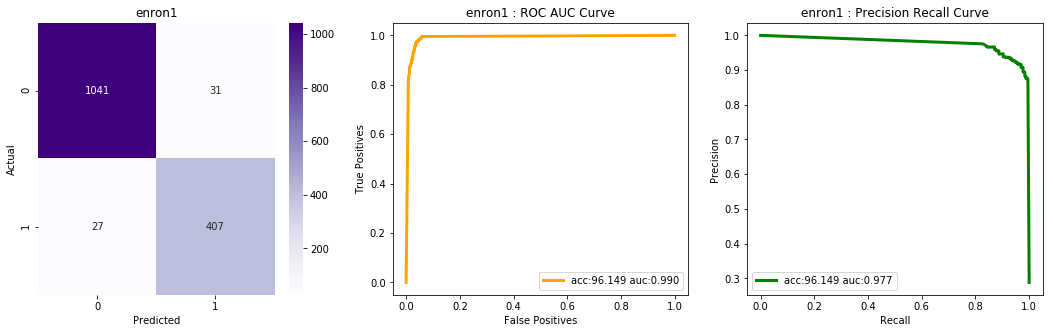

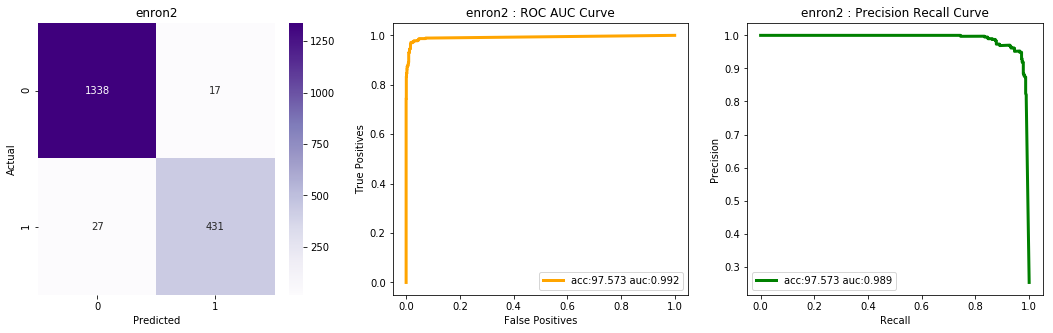

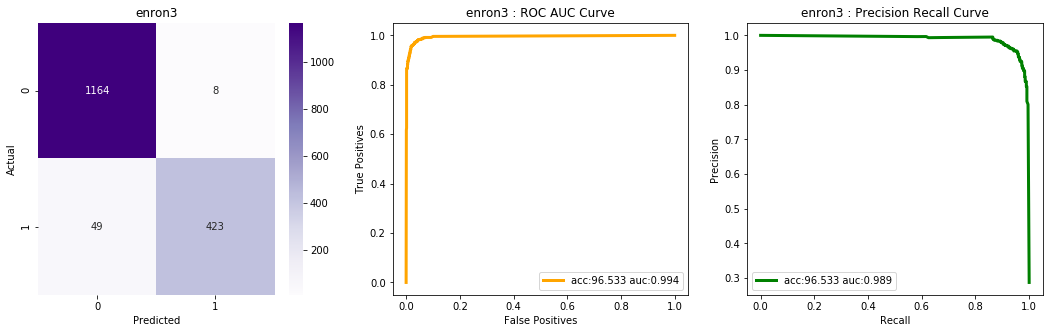

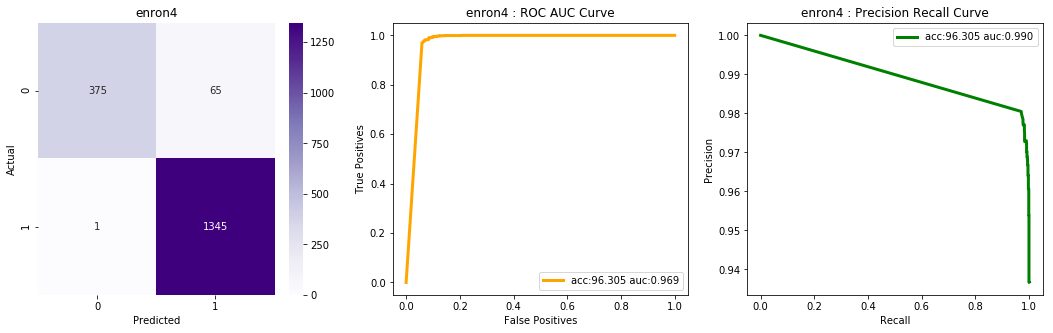

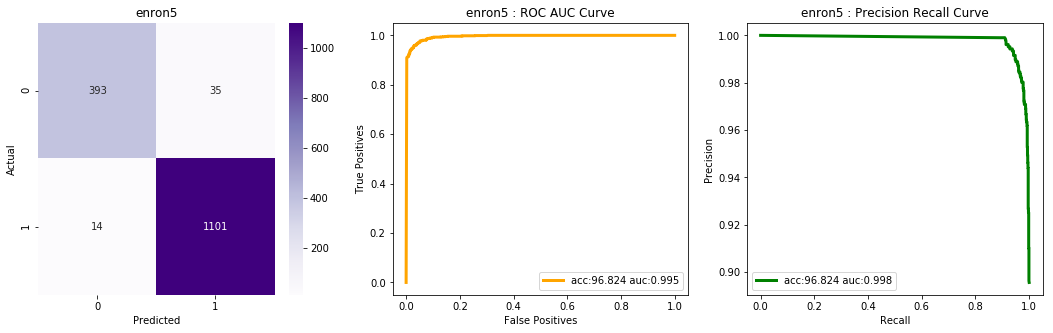

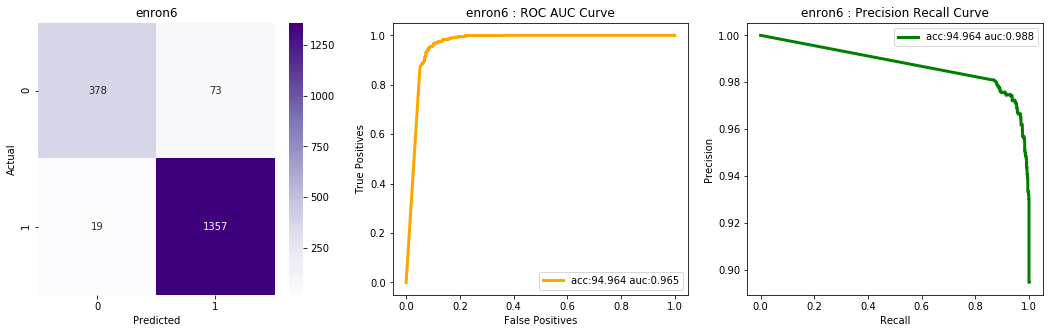

In [25]:
plot_all_evaluation_graphs(evaluated_metrics)

### 1.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [26]:
check_taste_of_various_users_using_DNN(modified_datasets, all_users_train_test_data)

Selected 5 random mails from : enron1 test set.
Printing first 300 characters of mails to get idea about contents.
subject online pharmacy buy drug online online pharmacy visit online store sa
subject august iferc sd noms attached august nomination take gas sale purchas
subject want rolex watch
subject proccess credit card online hispanic knapp need affordable reliable w
subject new soft new qem software http www allsoftbest info adobe photoshop i
Evaluating them on all users model
enron1 Model Predictions : [1 0 1 1 1], True : [1. 0. 1. 1. 1.]
enron2 Model Predictions : [1 0 0 0 0], True : [1. 0. 1. 1. 1.]
enron3 Model Predictions : [0 0 0 0 0], True : [1. 0. 1. 1. 1.]
enron4 Model Predictions : [1 1 1 1 1], True : [1. 0. 1. 1. 1.]
enron5 Model Predictions : [1 1 1 1 1], True : [1. 0. 1. 1. 1.]
enron6 Model Predictions : [1 1 1 1 1], True : [1. 0. 1. 1. 1.]
Selected 5 random mails from : enron2 test set.
Printing first 300 characters of mails to get idea about contents.
subject info e

In [27]:
#%%time
#num_max = 15000 ## Maximum number of words to keep in dictionary.
#evaluated_metrics, modified_datasets = evaluate_DNN_model(num_max, all_users_train_test_data,mode='tfidf')

In [28]:
#plot_all_evaluation_graphs(evaluated_metrics)

In [29]:
#check_taste_of_various_users_using_DNN(modified_datasets)

In [30]:
#num_max = 15000 ## Maximum number of words to keep in dictionary.
#evaluated_metrics, modified_datasets = evaluate_DNN_model(num_max, all_users_train_test_data,mode='binary')

In [31]:
#plot_all_evaluation_graphs(evaluated_metrics)

In [32]:
#check_taste_of_various_users_using_DNN(modified_datasets)

In [33]:
#num_max = 15000 ## Maximum number of words to keep in dictionary.
#evaluated_metrics = evaluate_DNN_model(num_max, all_users_train_test_data,mode='freq')

In [34]:
#plot_all_evaluation_graphs(evaluated_metrics)

In [35]:
#check_taste_of_various_users_using_DNN(modified_datasets)

## 2. CNN
### 2.1 Train And Evaluate
Below we have called method `evaluate_CNN_model` which will initilize Convolutional Neural Network according to parameters and train it for all users.After evaluation is done, it returns evaluated metrics on test set.

In [36]:
max_len=300
num_max = 15000 ## Maximum number of words to keep in dictionary.
evaluated_metrics, modified_datasets = evaluate_CNN_model(num_max, max_len, all_users_train_test_data)

Training For User :  enron1
Number of words in dictionary :  6992
Train/Test Datasets Shapes :  (3666, 300) (3666,) (1506, 300) (1506,)
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train Accuracy : 97.791 %
Test Accuracy : 94.090 %
Log Loss : 2.041
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      1072
         1.0       0.89      0.91      0.90       434

   micro avg       0.94      0.94      0.94      1506
   macro avg       0.93      0.93      0.93      1506
weighted avg       0.94      0.94      0.94      1506

Training For User :  enron2
Number of words in dictionary :  7400
Train/Test Datasets Shapes :  (4044, 300) (4044,) (1813, 300) (1813,)
Train Accuracy : 97.577 %
Test Accuracy : 93.491 %
Log Loss : 2.248
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      1355
         1.0       0.86     

### 2.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

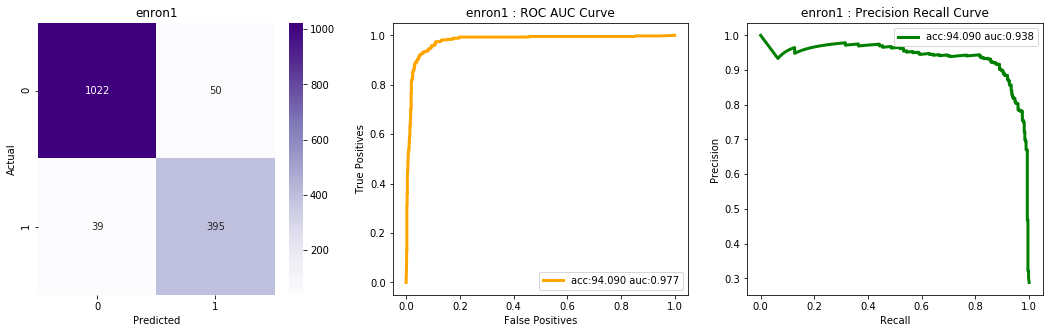

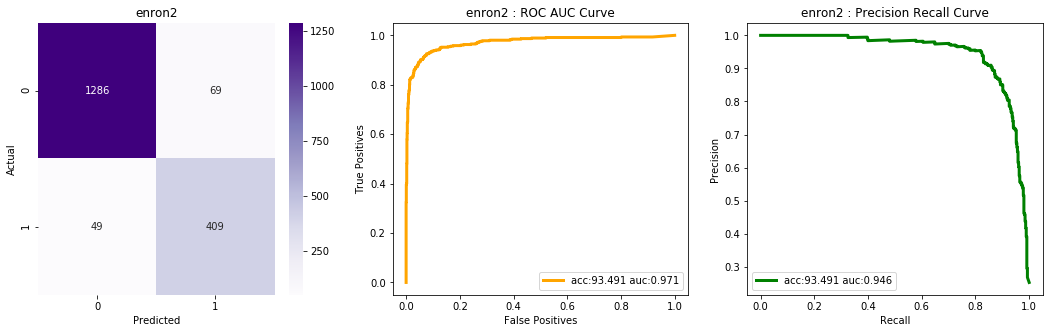

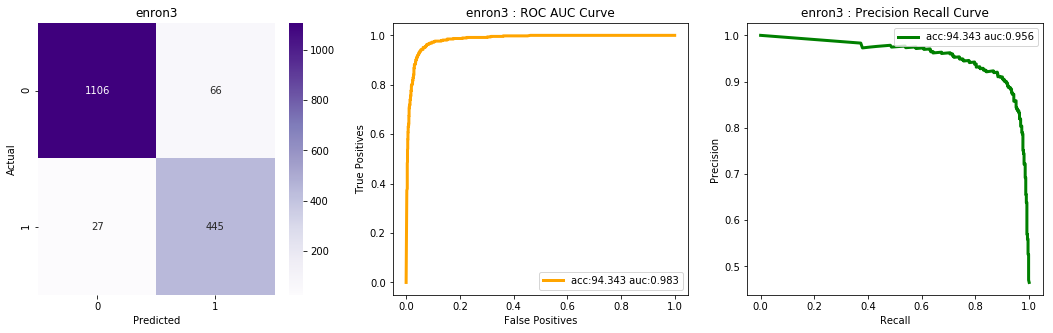

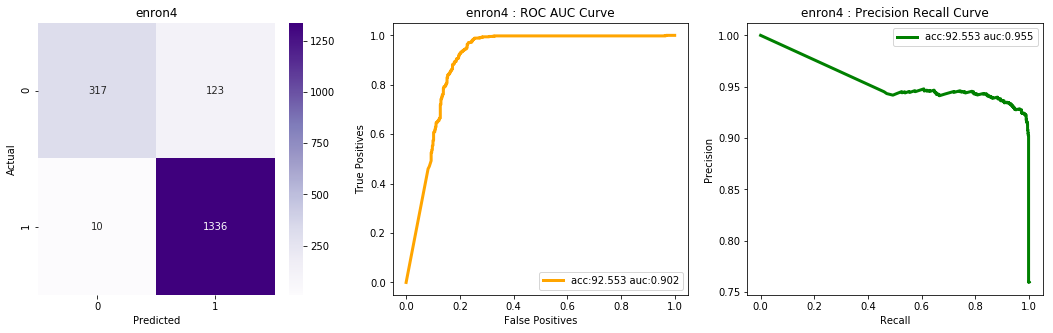

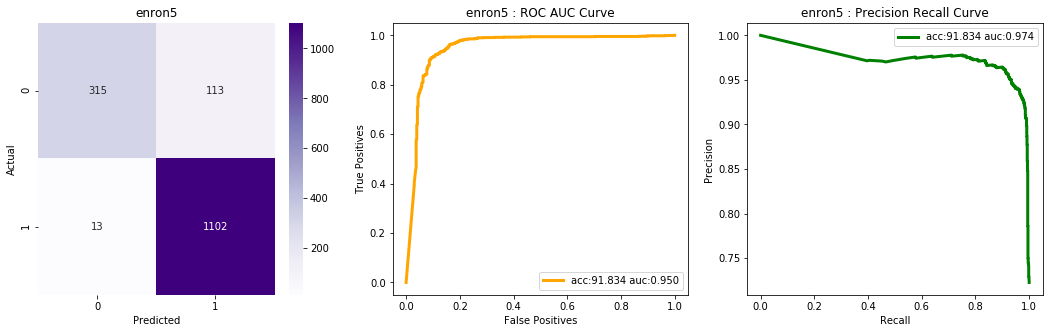

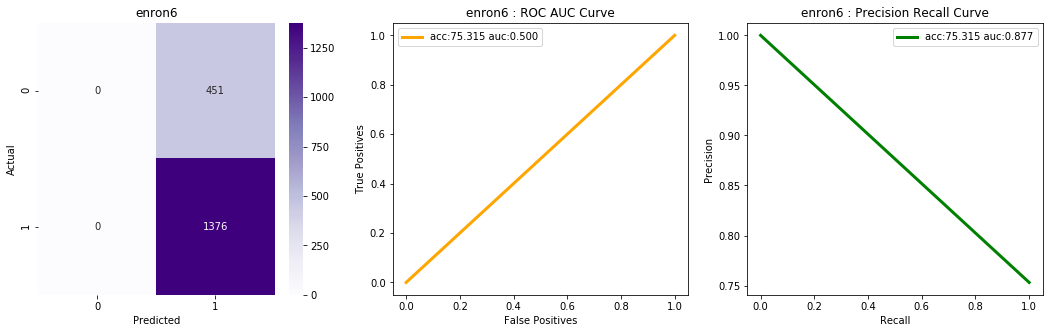

In [37]:
plot_all_evaluation_graphs(evaluated_metrics)

### 2.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [38]:
check_taste_of_various_users_using_CNN(modified_datasets,all_users_train_test_data)

Selected 5 random mails from : enron1 test set.
Printing first 300 characters of mails to get idea about contents.
subject paliourg bespoke nn yqloyfgwtfq b g z wvuscazkgyxonvx eefaircd nzbsud
subject meet woman area want f u c k htmlhead headbodycenterfont size face ar
subject cialis xanax valium viagra low price prescription needed discount rx 
subject sweet virgin love hard sex first time sex young boy fuck young girl y
subject extend th e best quality soft oem cd shop stock limited offer valid t
Evaluating them on all users model
enron1 Model Predictions : [1 1 1 1 0], True : [1. 1. 1. 1. 1.]
enron2 Model Predictions : [0 0 0 0 0], True : [1. 1. 1. 1. 1.]
enron3 Model Predictions : [0 1 0 1 0], True : [1. 1. 1. 1. 1.]
enron4 Model Predictions : [1 1 1 1 1], True : [1. 1. 1. 1. 1.]
enron5 Model Predictions : [1 1 0 1 1], True : [1. 1. 1. 1. 1.]
enron6 Model Predictions : [1 1 1 1 1], True : [1. 1. 1. 1. 1.]
Selected 5 random mails from : enron2 test set.
Printing first 300 character

## 3. CNN
### 3.1 Train And Evaluate
Below we have called method `evaluate_CNN_model` which will initilize Convolutional Neural Network according to parameters and train it for all users.After evaluation is done, it returns evaluated metrics on test set.

In [39]:
max_len=100
num_max = 15000 ## Maximum number of words to keep in dictionary.
evaluated_metrics, modified_datasets = evaluate_CNN_model(num_max, max_len, all_users_train_test_data)

Training For User :  enron1
Number of words in dictionary :  6992
Train/Test Datasets Shapes :  (3666, 100) (3666,) (1506, 100) (1506,)
Train Accuracy : 88.189 %
Test Accuracy : 88.513 %
Log Loss : 3.968
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      1072
         1.0       0.76      0.88      0.82       434

   micro avg       0.89      0.89      0.89      1506
   macro avg       0.85      0.88      0.87      1506
weighted avg       0.89      0.89      0.89      1506

Training For User :  enron2
Number of words in dictionary :  7400
Train/Test Datasets Shapes :  (4044, 100) (4044,) (1813, 100) (1813,)
Train Accuracy : 98.393 %
Test Accuracy : 95.422 %
Log Loss : 1.581
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1355
         1.0       0.89      0.94      0.91       458

   micro avg       0.95      0.95      0.95      18

### 3.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

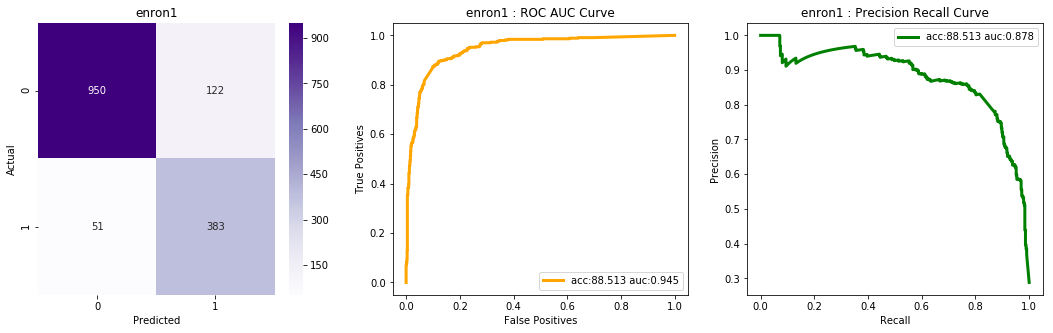

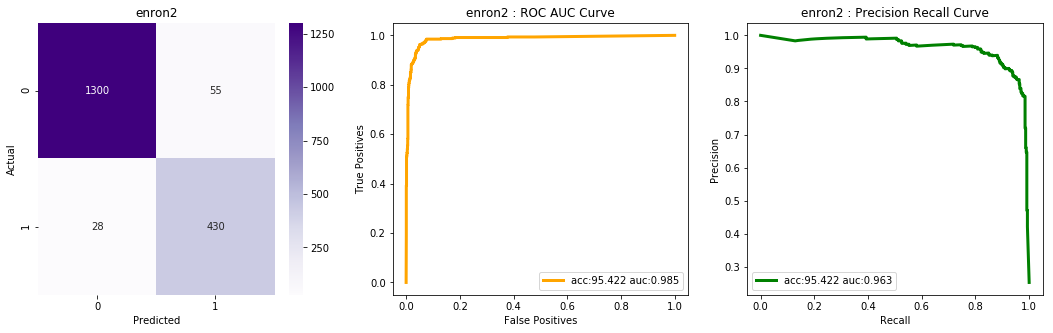

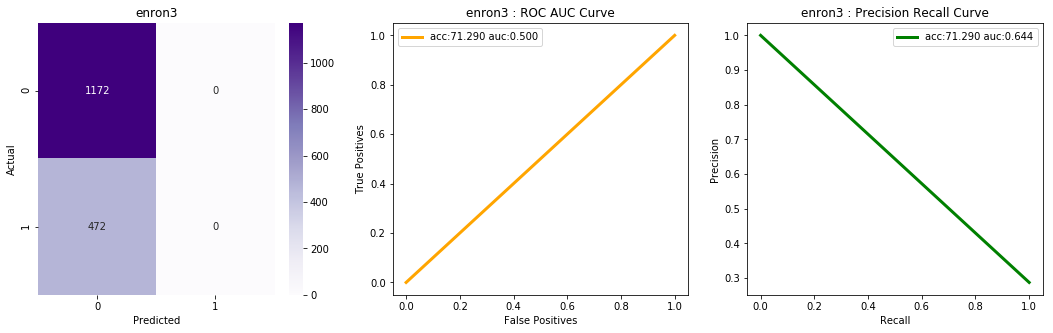

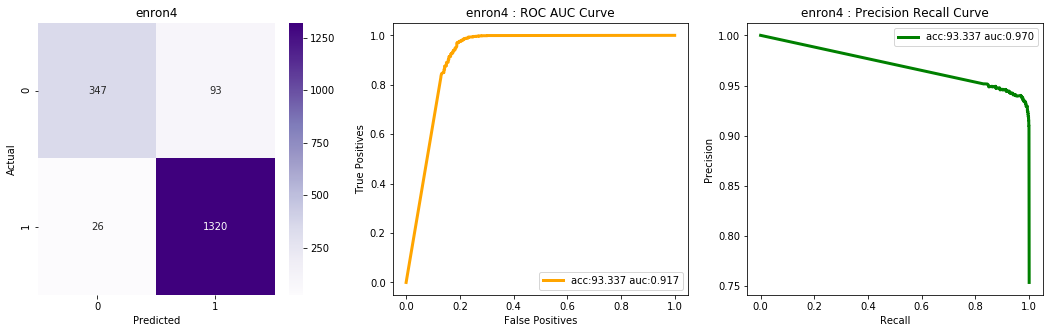

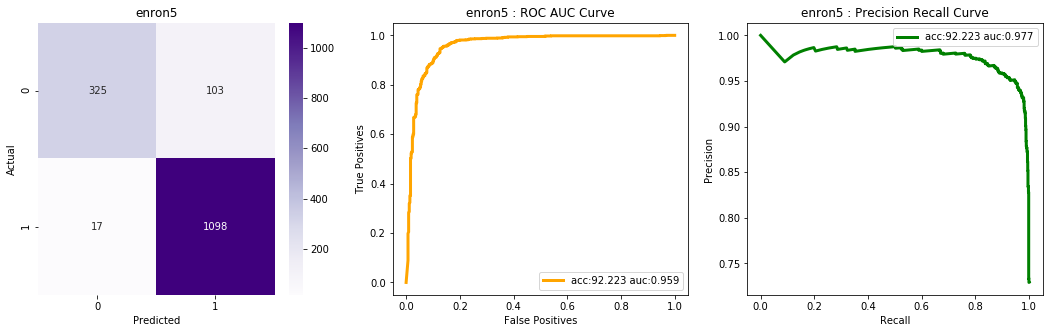

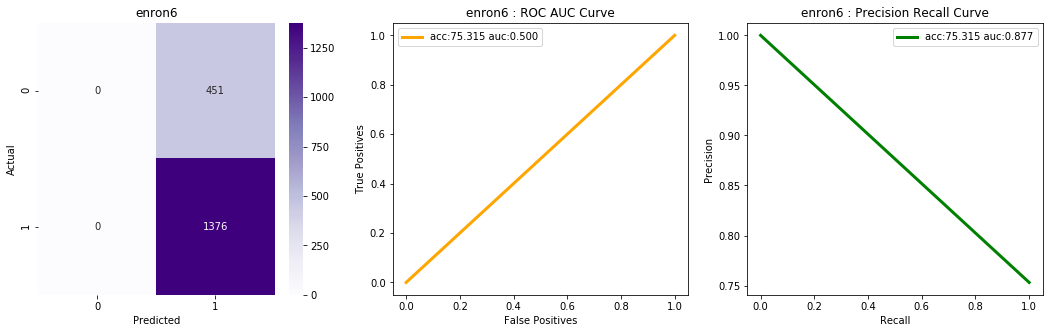

In [40]:
plot_all_evaluation_graphs(evaluated_metrics)

### 3.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [41]:
check_taste_of_various_users_using_CNN(modified_datasets, all_users_train_test_data)

Selected 5 random mails from : enron1 test set.
Printing first 300 characters of mails to get idea about contents.
subject get great price medication discount generic drug save today special v
subject viicodin zui huge med choose great discount save uup major brand med 
subject fwd real buy v lium xan x vlcodi n sio pnt e rmin okmydykwvnft provid
subject ask tina go luuuuuuube make happy make u happy well evergreen bullfin
subject extend th e best quality soft oem cd shop stock limited offer valid t
Evaluating them on all users model
enron1 Model Predictions : [1 0 1 0 1], True : [1. 1. 1. 1. 1.]
enron2 Model Predictions : [0 0 1 1 1], True : [1. 1. 1. 1. 1.]
enron3 Model Predictions : [0 0 0 0 0], True : [1. 1. 1. 1. 1.]
enron4 Model Predictions : [1 1 1 1 1], True : [1. 1. 1. 1. 1.]
enron5 Model Predictions : [1 0 1 1 0], True : [1. 1. 1. 1. 1.]
enron6 Model Predictions : [1 1 1 1 1], True : [1. 1. 1. 1. 1.]
Selected 5 random mails from : enron2 test set.
Printing first 300 character

In [42]:
#max_len=50
#num_max = 15000 ## Maximum number of words to keep in dictionary.
#evaluated_metrics, modified_datasets = evaluate_CNN_model(num_max, max_len, all_users_train_test_data)

In [43]:
#plot_all_evaluation_graphs(evaluated_metrics)

In [44]:
#check_taste_of_various_users_using_CNN(modified_datasets)